<a href="https://colab.research.google.com/github/chesnokkk/Pytorch_classification_cnn/blob/main/classification_sh2022(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/sh2022-dataset


 99% 1.68G/1.69G [00:11<00:00, 166MB/s]
100% 1.69G/1.69G [00:12<00:00, 151MB/s]


In [ ]:
!unzip sh2022-dataset.zip

In [ ]:
!pip install python-box
!pip install albumentations==0.4.6

import os
import glob
from box import Box
from pathlib import Path

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.functional import F
from albumentations import *
from albumentations.pytorch import ToTensorV2

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    'TRAIN_PATH': '/content/dataset/train',
    'TEST_PATH': '/content/dataset/test',
    'epochs': 10,
    'lr': 10e-3,
    'BATCH_SIZE':256,
    'seed':42,
    'height':224,
    'width':224,
    'device':DEVICE,
}

cfg = Box(config)
print(cfg.device)

cuda


In [6]:
# seeding in order to reproduce
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    print('seeding done!!!')
seeding(cfg.seed)

seeding done!!!


In [7]:
#create label_list
labels = os.listdir(cfg.TRAIN_PATH)
print(len(labels))
label_map = dict(zip(labels, [i for i in range(len(labels))]))
label_map

24


{'Ant Man': 12,
 'Aquaman': 18,
 'Batman': 21,
 'Black Panther': 23,
 'Black Widow': 17,
 'Captain America': 2,
 'Captain Marvel': 20,
 'Deadpool': 16,
 'Dr Strange': 1,
 'Falcon': 5,
 'Flash': 15,
 'Green Lantern': 7,
 'Hawkeye': 0,
 'Hulk': 10,
 'Iron Man': 14,
 'Joker': 13,
 'Nebula': 9,
 'Rocket Raccon': 19,
 'Scarlet Witch': 4,
 'Shazam': 6,
 'Spider Man': 22,
 'Super Man': 8,
 'Thor': 11,
 'Wonder Woman': 3}

In [8]:
#create dataframe of paths
def create_df(path):
    path_list = []
    label_list = []

    for label in labels:
        for (dirpath, dirnames, images) in \
        os.walk(os.path.join(path, label)):
            for image in images:
                path_list.append(os.path.join(dirpath, image))
                label_list.append(label)
    return pd.DataFrame({'path':path_list, 'label':label_list})

all_test_data = create_df(cfg.TEST_PATH)
all_train_data = create_df(cfg.TRAIN_PATH)

In [7]:
# data were already augumented. 
#I will eval on a part of the training dataset and test data from the directory

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    all_train_data['path'],
    all_train_data['label'],
    test_size=0.1,
    random_state=cfg.seed
)

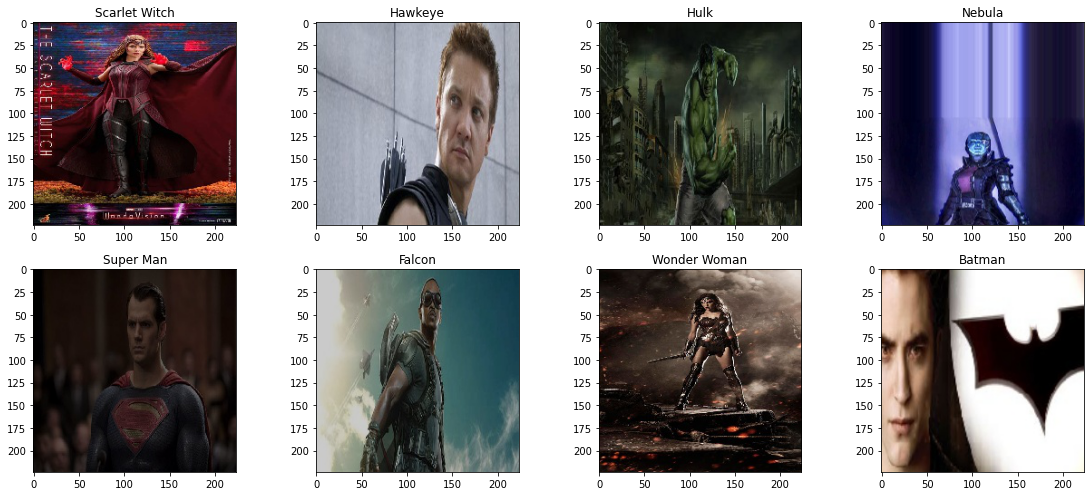

In [10]:
#show images
fig, axes = plt.subplots(2,4, figsize=(16, 7))
random_idxs = [random.randint(0, len(all_train_data['path'])) for _ in axes.flat]

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(all_train_data['path'].iloc[random_idxs[i]]))
    ax.set_title(all_train_data['label'].iloc[random_idxs[i]])
plt.tight_layout()
plt.show()

In [11]:
class ImageDataset(Dataset):
    def __init__(self, labels, paths, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_paths = paths
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.img_paths.iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = label_map[self.img_labels.iloc[idx]]
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"].float() 
        if self.target_transform:
            transformed = self.target_transform(image=image)
            image = transformed["image"].float() 
        return image, label

In [12]:
#data already augumented, it need add ToTensor() in this case
transform = Compose([
        Resize(cfg.height, cfg.width),
        #ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2),
        #RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        #OneOf([GaussianBlur(),GaussNoise()], p=0.2),
        #Normalize(),
        ToTensorV2()
    ])

target_transform = Compose([
        Resize(cfg.height, cfg.width),       
        #Normalize(),
        ToTensorV2()
    ]) 

In [14]:
#create dataloaders
train_dataset = ImageDataset(
    y_train, X_train,transform=transform
)
val_dataset = ImageDataset(
    y_val, X_val, target_transform=target_transform
)
test_dataset = ImageDataset(
    all_test_data['label'], all_test_data['path'], target_transform=target_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)


Feature batch shape: torch.Size([256, 3, 224, 224])


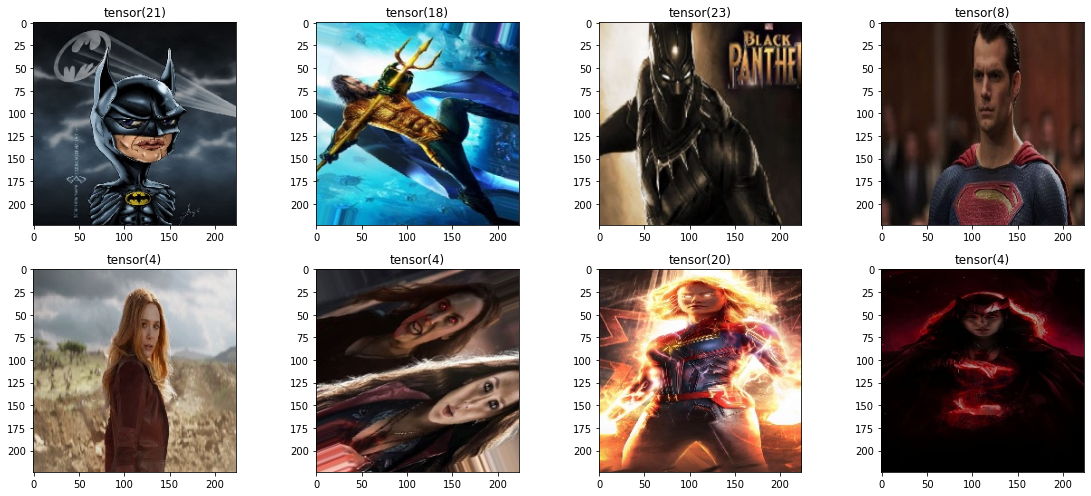

In [15]:
# Display image and label from dataloader

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")

fig, axes = plt.subplots(2,4, figsize=(16, 7))
for _, ax in enumerate(axes.flat):
    train_features, train_labels = next(iter(train_dataloader))
    img = train_features[0].byte().squeeze()
    ax.imshow(img.permute(1,2,0))
    ax.set_title(train_labels[0])
plt.tight_layout()
plt.show()

In [42]:
class BasicClassificationModel(nn.Module):
    def __init__(self):
        super(BasicClassificationModel, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15)
        
        self.conv1 = nn.Conv2d(3, 16, 5, padding=1, stride=2) 
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
           
        self.linear1 = nn.Linear(64*12*12, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, len(labels))
    
    def forward(self, x):
        x = self.batchnorm1(self.maxpool(self.relu(self.conv1(x)))) #((224-5+2)/2+1)/2 = 55
        x = self.batchnorm2(self.maxpool(self.relu(self.conv2(x)))) #(55-3+1)/2 = 26
        x = self.batchnorm3(self.maxpool(self.relu(self.conv3(x)))) #(26-3+1)/2 = 12

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear3(x)
        return pred
        
        

In [43]:
model = BasicClassificationModel()
model.to(DEVICE)

BasicClassificationModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=9216, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=24, bias=True)
)

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [45]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,test_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    history['test_loss'] = []
    history['test_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0

        for batch in train_dl:
            # Compute prediction error
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item() * x.size(0)
            num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dl.dataset)

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0
        
        test_loss = 0.0
        num_test_correct = 0
        num_test_examples = 0

        for batch in val_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)
        
        for batch in test_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            test_loss += loss.data.item() * x.size(0)
            num_test_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_test_examples += y.shape[0]

        test_acc = num_test_correct / num_test_examples
        test_loss = test_loss / len(test_dl.dataset)
    
        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
            (epoch, epochs, train_loss, train_acc, val_loss, val_acc))
        print('test loss: %5.2f, test acc: %5.2f' % \
            (test_loss, test_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

    # END OF TRAINING LOOP


    end_time_sec = time.time()
    total_time_sec = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [46]:
history = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dl=train_dataloader,
    test_dl=test_dataloader, 
    val_dl=val_dataloader,
    epochs=cfg.epochs,
    device=cfg.device)

train() called: model=BasicClassificationModel, opt=Adam(lr=0.000100), epochs=10, device=cuda

Epoch   1/ 10, train loss:  1.60, train acc:  0.56, val loss:  0.79, val acc:  0.79
test loss:  1.52, test acc:  0.59
Epoch   2/ 10, train loss:  0.63, train acc:  0.83, val loss:  0.48, val acc:  0.87
test loss:  1.54, test acc:  0.60
Epoch   3/ 10, train loss:  0.35, train acc:  0.91, val loss:  0.37, val acc:  0.90
test loss:  1.55, test acc:  0.62
Epoch   4/ 10, train loss:  0.20, train acc:  0.95, val loss:  0.31, val acc:  0.91
test loss:  1.64, test acc:  0.62
Epoch   5/ 10, train loss:  0.11, train acc:  0.98, val loss:  0.30, val acc:  0.92
test loss:  1.73, test acc:  0.61
Epoch   6/ 10, train loss:  0.06, train acc:  0.99, val loss:  0.29, val acc:  0.92
test loss:  1.88, test acc:  0.62
Epoch   7/ 10, train loss:  0.04, train acc:  0.99, val loss:  0.28, val acc:  0.93
test loss:  1.91, test acc:  0.61
Epoch   8/ 10, train loss:  0.03, train acc:  1.00, val loss:  0.28, val acc:  

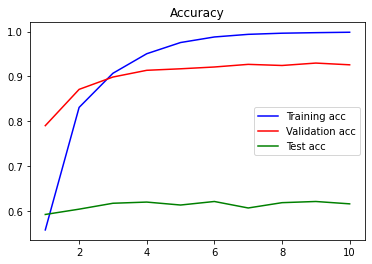

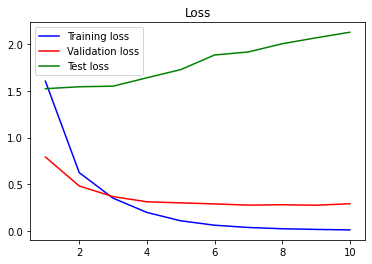

In [47]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
test_loss = history['test_loss']
test_acc = history['test_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.plot(epochs, test_acc, 'g', label='Test acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, test_loss, 'g', label='Test loss')
plt.title('Loss')
plt.legend()
plt.show()